# Occlusion

In this exercise you will implement a *vanilla occlusion* explainer for images.

**Goals** (20 minutes)
1. Load a pre-trained classifier (Inception‑v4) and a small image set (provided as `.npy`)
2. Load the data and preview
3. Select an image from the four image dataset and compute the unmasked prediction
4. Implement a **sliding window** mask with configurable *window size*, *stride*, and *baseline value*.
5. For each masked variant, run the model and record the target-class probability and its **distance** from the unmasked probability.
6. Visualize: (a) a grid of masked images + scores, (b) a **Δ heatmap** overlay on the original image.
7. Change the kernal size and report obsevations 
8. Change the basline and report obsevations
9. Implement the open source Captum solution and compare results 

> Fill in each `# YOUR CODE HERE` with the missing lines. Hints provided inline. Small asserts help you verify shapes.

In [ ]:
# Load necessary libraries

import utils # set of helper functions
import torch # pytorch for deep learning
import cv2 # opencv for image manipulation
import numpy as np # numpy for matrix operations
from timm import create_model # timm for loading pre-trained models
import matplotlib.pyplot as plt # matplotlib for plotting
from utils import custom_cmap # custom color map for visualizing attributions
from captum.attr import Occlusion # captum built in attribution methods
from torchvision.models import inception_v3 # torchvision for loading pre-trained models
import warnings # to suppress warnings
warnings.filterwarnings("ignore") # ignore warnings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to GPU if available, otherwise CPU

### 1) Load model (Inception‑v3, ImageNet)

In [ ]:
# Load the pre-trained inception_v3 model and set it to evaluation mode
model = inception_v3(pretrained=True)
model.eval();

### 2) Load data and preview

Assume `.npy` files with shapes: `images: (N, 299, 299, 3)` in **[-1, 1]**, `labels: (N,)` class indices.

In [61]:
# load images 
images = np.load('../data/images.npy') # images are 299 by 299 and normalize dbetween -1 and 1
# Load corresponding labels
labels = np.load('../data/labels.npy')
print(images.shape, labels.shape)

(4, 299, 299, 3) (4,)


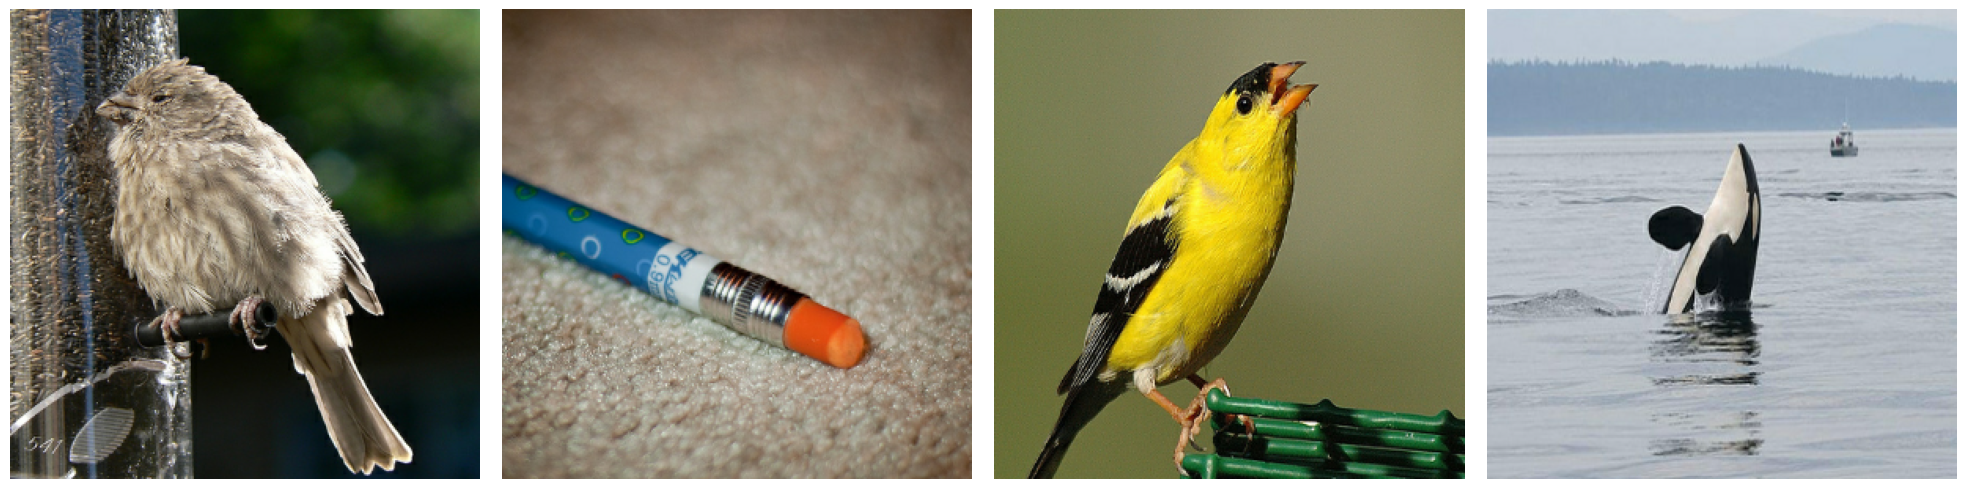

In [62]:
# Plot all normalized images using utils function so the images look good
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i in range(images.shape[0]):
    axs[i].imshow(utils.normalize(images[i]))
    axs[i].axis('off')
    plt.tight_layout()
plt.show()
plt.close(fig)
# Index 1 = Finch, Index 2 = pencil, Index 3 = bird, Index 4 = whale

### 3) Select an image and compute the **unmasked** prediction

- Convert image HWC → CHW tensor in **(-1,1)**
- Compute softmax probabilities and note the **top‑1** class and probability.

In [63]:
# 1. Select an Image

image_index = 1
sample_image = images[image_index] # Shape (H, W, C)
sample_label = labels[image_index] if len(labels) > image_index else "Unknown"

# It's always a good idea to check the shape of our data!
# The format is (Height, Width, Channels), often called HWC.
print(f"Original image shape: {sample_image.shape} -> (Height, Width, Channels)")

Original image shape: (299, 299, 3) -> (Height, Width, Channels)


In [64]:
# 2. Pre-process the Image for PyTorch

# Models don't work with images directly; they need them in a specific format called a 'tensor'.

# Step 2a: Change layout from HWC to CHW
# PyTorch models expect the channel dimension to be first: (Channels, Height, Width)
image_chw = np.transpose(sample_image, (2, 0, 1))
print(f"Shape after transpose: {image_chw.shape} -> (Channels, Height, Width)")

# Step 2b: Convert from NumPy array to a PyTorch Tensor
image_tensor = torch.from_numpy(image_chw.astype(np.float32))

# Step 2c: Add a "batch" dimension
# Models are designed to work on a 'batch' of images at once. 
# We add a new dimension to say "this is a batch containing 1 image".
# Shape becomes: (Batch Size, Channels, Height, Width)
image_batch = image_tensor.unsqueeze(0)
print(f"Shape after adding batch dimension: {image_batch.shape} -> (Batch, C, H, W)")

# Step 2d: Move the tensor to the correct device (CPU or GPU)
input_tensor = image_batch.to(device)

Shape after transpose: (3, 299, 299) -> (Channels, Height, Width)
Shape after adding batch dimension: torch.Size([1, 3, 299, 299]) -> (Batch, C, H, W)


In [65]:
# 3. Make the Prediction 

# We use torch.no_grad() to tell PyTorch that we not training the model,
# which saves memory and computation.
with torch.no_grad():
    # Get the raw model outputs (called 'logits').
    # Logits are the raw, unnormalized scores output by the model.
    # Shape should be (Batch Size, Num Classes)
    logits = model(input_tensor) 
    
    # Convert logits to probabilities using the softmax function
    # Shape should be (Batch Size, Num Classes)
    probabilities = torch.softmax(logits, dim=1)

In [66]:
# 4. Find the Top Class and its Probability

# Find the class with the highest probability
top_probability = probabilities.max()
top_class_index = probabilities.argmax()

In [67]:
# 5. Interpret the Results
# .item() is used to extract the single number from a tensor
print(f"\n--- Prediction ---")
print(f"Target Class (top-1): {top_class_index.item()}")
print(f"Confidence: {top_probability.item():.4f}")
if sample_label != "Unknown":
    print(f"Actual Label: {sample_label}")


--- Prediction ---
Target Class (top-1): 767
Confidence: 0.7392
Actual Label: 767


### 4) Implement **sliding‑window** occlusion. 
Use this code block as is.

In [68]:
# Convert to CHW tensor
def to_chw_tensor(img_hwc: np.ndarray) -> torch.Tensor:
    # Convert HWC [-1,1] -> CHW
    chw = np.transpose(img_hwc, (2, 0, 1)).astype(np.float32)
    t = torch.from_numpy(chw).unsqueeze(0)  # [1,C,H,W]
    return t

# Sliding window occlusion utilities
def sliding_window_positions(H: int, W: int, win: int, stride: int):
    ys = list(range(0, max(1, H - win + 1), stride))
    xs = list(range(0, max(1, W - win + 1), stride))
    if ys[-1] != H - win:
        ys.append(H - win)
    if xs[-1] != W - win:
        xs.append(W - win)
    for y in ys:
        for x in xs:
            yield y, x

def apply_mask(img_hwc: np.ndarray, y: int, x: int, win: int, baseline: float = 0.0):
    out = img_hwc.copy()
    out[y:y+win, x:x+win, :] = baseline
    return out

# Occlusion scan function 
# This function performs an occlusion scan on the input image using the specified model.
# It slides a window across the image, applies a mask, and computes the model's predictions for each masked image. 
# It returns the results  wich includes the position of the window,
# the predicted probability for the target class, and the absolute difference from the true probability.
def occlusion_scan(model, img_hwc: np.ndarray, win: int = 50, stride: int = 50,
                   baseline: float = 0.0, target_class: int = None, device=None):
    if device is None:
        device = next(model.parameters()).device

    x0 = to_chw_tensor(img_hwc).to(device)
    with torch.no_grad():
        p0 = torch.softmax(model(x0), dim=-1)
        if target_class is None:
            target_class = int(p0.argmax(dim=-1))
        p_true = float(p0[0, target_class])

    results = []
    for (y, x) in sliding_window_positions(img_hwc.shape[0], img_hwc.shape[1], win, stride):
        masked = apply_mask(img_hwc, y, x, win, baseline=baseline)
        xt = to_chw_tensor(masked).to(device)
        with torch.no_grad():
            p = torch.softmax(model(xt), dim=-1)[0, target_class].item()
        results.append({'y': y, 'x': x, 'win': win, 'p': p, 'delta': abs(p - p_true), 'image': masked})
    return results, target_class, p_true 

### 5) For each masked variant, run the model and record the results

In [69]:
# Run occlusion on the image 
WIN = 100 # window size
STRIDE = 100 # stride
BASELINE = 0.0 # baseline

results, tgt, p_true = occlusion_scan(model, sample_image, win=WIN, stride=STRIDE, baseline=BASELINE, target_class=None, device=device)
print(f'Occlusion produced {len(results)} masked variants. Target class = {tgt}, p_true = {p_true:.4f}')

Occlusion produced 9 masked variants. Target class = 767, p_true = 0.7392


### 6) Visualize: a grid of masked images + scores

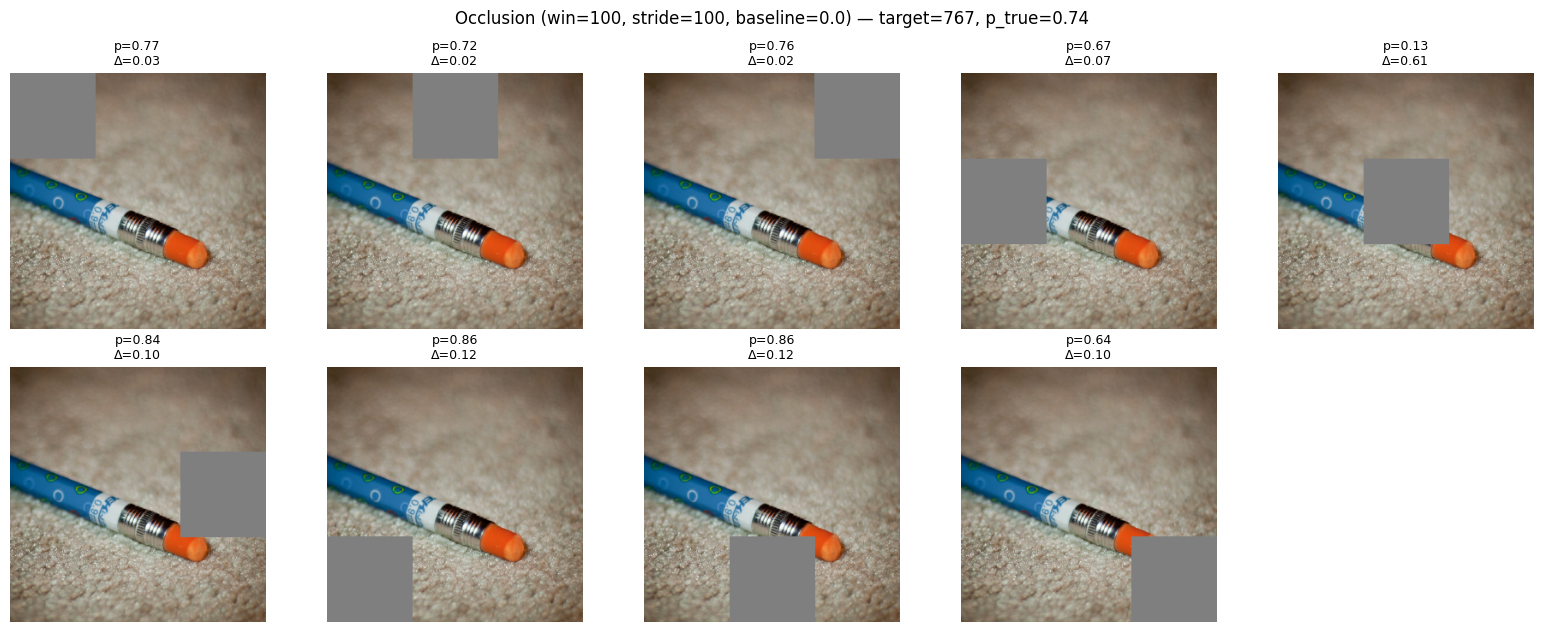

In [70]:
# Visualize masked images with predictions and distances 

n = len(results)
cols = 5
rows = int(np.ceil(n / cols))

fig, axs = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
axs = np.array(axs).reshape(rows, cols)
for ax in axs.ravel():
    ax.axis('off')

for i, r in enumerate(results):
    ax = axs.ravel()[i]
    ax.imshow((r['image'] + 1.0)/2.0)  # map [-1,1] -> [0,1]
    ax.set_title(f"p={r['p']:.2f}\nΔ={r['delta']:.2f}", fontsize=9)
    ax.axis('off')

plt.suptitle(f'Occlusion (win={WIN}, stride={STRIDE}, baseline={BASELINE}) — target={tgt}, p_true={p_true:.2f}')
plt.tight_layout()
plt.show()

### 7) Generate saliency map

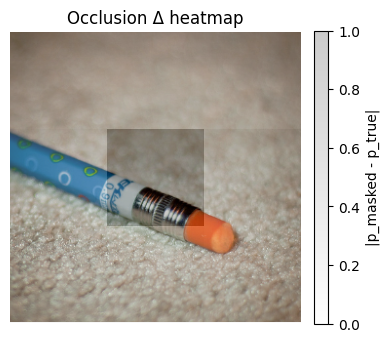

In [71]:
W, H = sample_image.shape[1], sample_image.shape[0]

grid_y = sorted(set([r['y'] for r in results]))
grid_x = sorted(set([r['x'] for r in results]))
delta_grid = np.zeros((len(grid_y), len(grid_x)), dtype=np.float32)
for r in results:
    yi = grid_y.index(r['y'])
    xi = grid_x.index(r['x'])
    delta_grid[yi, xi] = r['delta']

# Normalize the heatmap for visualization
heatmap = delta_grid.copy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-9)

plt.figure(figsize=(4, 4))
plt.imshow(utils.normalize(sample_image), origin='upper')
plt.imshow(
    heatmap,
    cmap='binary',
    alpha=0.2,                    # stronger overlay
    interpolation='nearest',      # blocky patches
    extent=[0, W, H, 0],          # align heatmap grid to image pixels
    vmin=0.0, vmax=1.0            # full dynamic range
)
plt.colorbar(label='|p_masked - p_true|', fraction=0.046, pad=0.04)
plt.title('Occlusion Δ heatmap')
plt.axis('off')
plt.tight_layout()
plt.show()

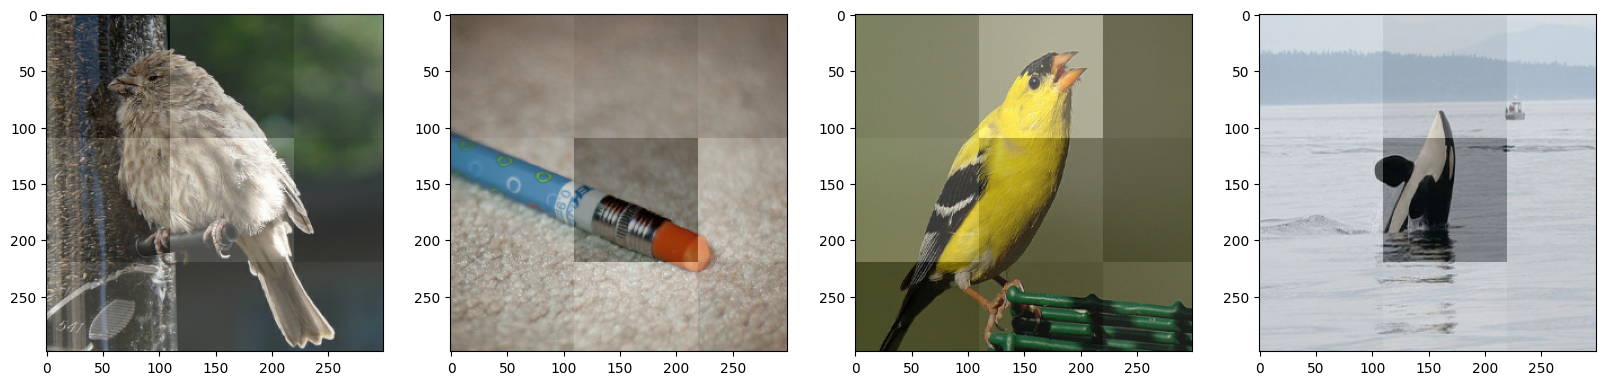

In [72]:
# Initialize Occlusion
occlusion = Occlusion(model)

# Plot occlusion reults for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])
    # Compute the occlusion saliency map
    saliency_map = occlusion.attribute(
        input_tensor,
        strides=(3, 110, 110),  # Strides for sliding window across channels, height, width
        target=target_class,  # Target class index
        sliding_window_shapes=(3, 110, 110),  # Window size for occlusion (channels, height, width)
    )
    # Convert attributions to numpy for visualization
    saliency_map = saliency_map.squeeze().detach().numpy()
    # avarage over color channels
    saliency_map = np.mean(saliency_map, axis=0)
    # Plot integrated gradients saliency map 
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(saliency_map, cmap='binary', alpha=0.3)